# Análisis Exploratorio (EDA) - PML Cancún
# **Objetivos**:
- Identificar patrones temporales (horarios, diarios, mensuales)
- Analizar la relación entre PML y congestión
- Detectar outliers y valores atípicos.
- Preparar datos para los modelos predictivos.

## 1. Carga de datos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

ruta = 'C:/Cursos/Data Science/Proyecto CENANCE/pml-cancun-forecasting/data/PML_CANCUN_FINAL.csv'

# Configuracion visual
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (15,5)
pd.set_option('display.max_columns', None)

# Cargar Datos
try:
    df = pd.read_csv(ruta, parse_dates=['fecha'])
    print("✅ Archivo cargado correctamente")
    print(f"📊 Dimensiones: {df.shape}")
    
    # Mostrar las primeras filas 
    print(df.head())

except Exception as e:
    print(f"❌ Error al cargar el archivo: {str(e)}")
    print("\n🔍 Verifica:")
    print(f"1. Que el archivo existe en: {ruta}")
    print("2. Que el nombre del archivo es exactamente 'PML_CANCUN_FINAL.csv'")
    print("3. Que no hay caracteres especiales en la ruta")


✅ Archivo cargado correctamente
📊 Dimensiones: (17470, 6)
        fecha  hora    zona  precio  energia  congestion
0  01/04/2020     1  CANCUN  897.55   518.12      231.15
1  01/04/2020     2  CANCUN  870.99   499.13      238.07
2  01/04/2020     3  CANCUN  852.32   475.58      259.21
3  01/04/2020     4  CANCUN  779.46   470.62      199.34
4  01/04/2020     5  CANCUN  983.23   466.05      416.27


## 2. Limpieza de Datos

Se revisaron los tipos de datos de cada columna para validar su correcta estrucutura:

- **fecha:** tipo object, debe convertirse a tipo **datetime** para análisis temporal.
- **hora:** tipo int64, respresenta la hora del día (de 1 a 24) se mantiene como entero.
- **zona:** tipo object, es una categoría geográfica (CANCUN) se puede transformar en tipo  category.
- **precio, energia, congestion:** tipo float64, son variables numéricas continuas y están correctamente definidas.

In [3]:
def parse_mixed_dates(date_str):
    try:
        # Primero intenta con formato AAAA-MM-DD
        return pd.to_datetime(date_str, format='%Y-%m-%d')
    except ValueError:
        try:
            # Si falla, intenta con formato DD/MM/AAAA
            return pd.to_datetime(date_str, format='%d/%m/%Y')
        except ValueError:
            # Si ambos fallan, devuelve NaT (Not a Time)
            return pd.NaT

# Aplicar la función a la columna de fechas
df['fecha'] = df['fecha'].apply(parse_mixed_dates)

# Verificar si hay fechas no convertidas
if df['fecha'].isna().any():
    print(f"⚠️ Advertencia: {df['fecha'].isna().sum()} fechas no pudieron convertirse")
    print("Registros problemáticos:")
    print(df[df['fecha'].isna()])
else:
    print("✅ Todas las fechas convertidas exitosamente")

# Combinar con la hora (1-24) para crear timestamp completo
df['fecha_hora'] = df['fecha'] + pd.to_timedelta(df['hora'] - 1, unit='h')

# Eliminar filas con fechas inválidas si es necesario
df = df.dropna(subset=['fecha'])

# Verificar resultados
print("\nEjemplo de fechas convertidas:")
print(df[['fecha', 'hora', 'fecha_hora']].head(3))
print("\nEjemplo del registro problemático convertido:")
print(df[df['fecha_hora'].dt.strftime('%d/%m/%Y') == '15/08/2024'].head())

✅ Todas las fechas convertidas exitosamente

Ejemplo de fechas convertidas:
       fecha  hora          fecha_hora
0 2020-04-01     1 2020-04-01 00:00:00
1 2020-04-01     2 2020-04-01 01:00:00
2 2020-04-01     3 2020-04-01 02:00:00

Ejemplo del registro problemático convertido:
          fecha  hora    zona   precio  energia  congestion  \
6093 2024-08-15     1  CANCUN  5770.44  1082.40     4418.25   
6094 2024-08-15     2  CANCUN   970.89   774.01       -0.12   
6095 2024-08-15     3  CANCUN   634.29   508.03       -0.25   
6096 2024-08-15     4  CANCUN   544.40   440.25       -0.19   
6097 2024-08-15     5  CANCUN   511.91   422.06       -0.14   

              fecha_hora  
6093 2024-08-15 00:00:00  
6094 2024-08-15 01:00:00  
6095 2024-08-15 02:00:00  
6096 2024-08-15 03:00:00  
6097 2024-08-15 04:00:00  


## 3. Análisis inicial

In [4]:
# Estructura de los datos
print(f"📊 Dimensiones: {df.shape}")
print(f"\n🔍 Muestra de datos:\n {df.head(3)}")
print(f"\n📅 Rango temporal: {df['fecha'].min()} a {df['fecha'].max()}")
print(f"\n❌ Valores nulos por columna:\n {df[['precio', 'energia', 'congestion']].describe()}")

📊 Dimensiones: (17470, 7)

🔍 Muestra de datos:
        fecha  hora    zona  precio  energia  congestion          fecha_hora
0 2020-04-01     1  CANCUN  897.55   518.12      231.15 2020-04-01 00:00:00
1 2020-04-01     2  CANCUN  870.99   499.13      238.07 2020-04-01 01:00:00
2 2020-04-01     3  CANCUN  852.32   475.58      259.21 2020-04-01 02:00:00

📅 Rango temporal: 2020-01-01 00:00:00 a 2025-04-30 00:00:00

❌ Valores nulos por columna:
              precio       energia    congestion
count  17470.000000  17470.000000  17470.000000
mean    1365.556263    720.273659    535.060517
std     1987.145443    478.614401   1844.344380
min        0.000000     -0.010000   -879.880000
25%      595.195000    485.030000      0.000000
50%      763.420000    599.545000      0.020000
75%     1236.472500    766.237500    155.300000
max    16065.410000  13719.620000  14045.670000


##

## 4. Visualización de Tendencias Temporales

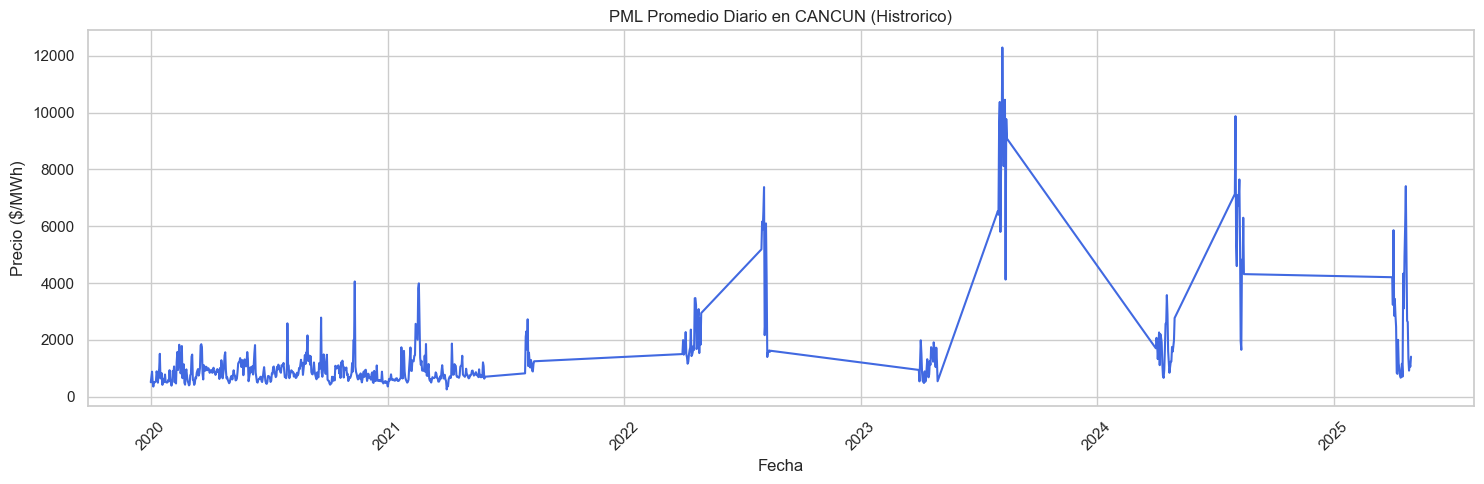

In [5]:
# Asegurar que 'Fecha' sea datetime
df['fecha'] = pd.to_datetime(df['fecha'], format='ISO8601')

df['fecha_hora'] = df['fecha'] + pd.to_timedelta(df['hora'] - 1, unit='h')

# Establecer 'Fecha' como índice
df.set_index('fecha_hora', inplace=True)

# Promedio diario del precio
df_diario = df['precio'].resample('D').mean()

# Visualización
plt.Figure(figsize=(15, 5))
sns.lineplot(data=df_diario, color='royalblue')
plt.title('PML Promedio Diario en CANCUN (Histrorico)')
plt.xlabel('Fecha')
plt.ylabel('Precio ($/MWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5.Estacionalidad y Patrones Horarios

C:\Users\Alex\AppData\Local\Temp\ipykernel_15340\1499290528.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hora', y='precio', palette='viridis')


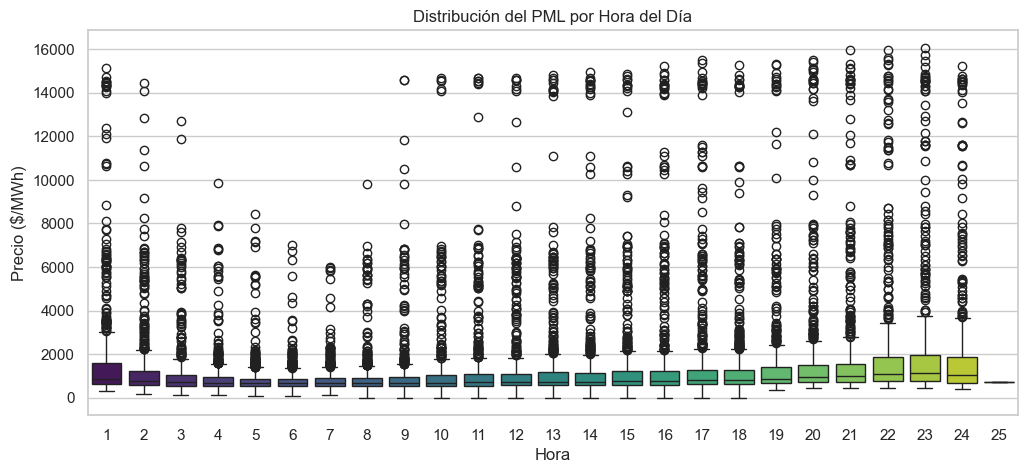

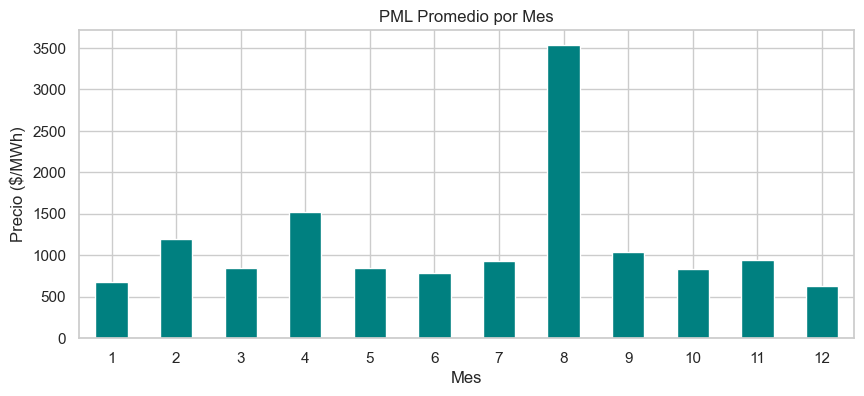

In [6]:
# Boxplot por hora
plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x='hora', y='precio', palette='viridis')
plt.title('Distribución del PML por Hora del Día')
plt.xlabel('Hora')
plt.ylabel('Precio ($/MWh)')
plt.show()

# Estacionalidad mensual
df_mes = df.groupby(df['fecha'].dt.month)['precio'].mean()
plt.figure(figsize=(10, 4))
df_mes.plot(kind='bar', color='teal')
plt.title('PML Promedio por Mes')
plt.xlabel('Mes')
plt.ylabel('Precio ($/MWh)')
plt.xticks(rotation=0)
plt.show()

## 6. Relación PML vs Congestión

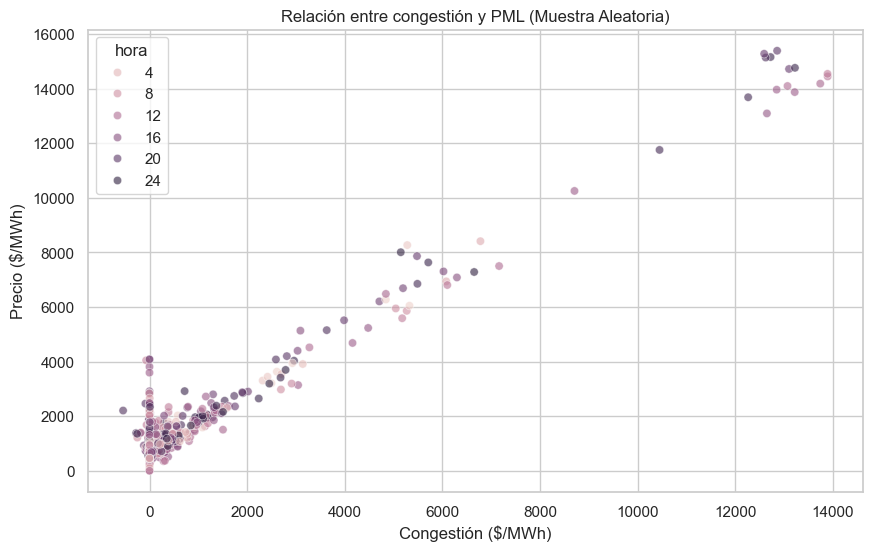

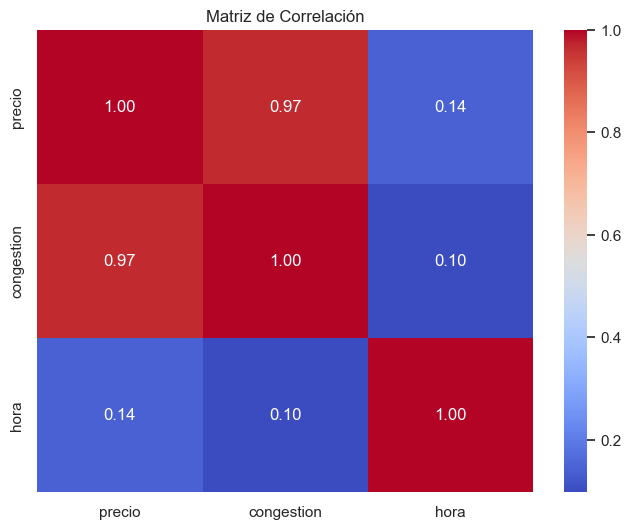

In [7]:
# Resetear indice 
df_plot = df.reset_index()
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot.sample(1000), x='congestion', y='precio', alpha=0.6, hue='hora')
plt.title('Relación entre congestión y PML (Muestra Aleatoria)')
plt.xlabel('Congestión ($/MWh)')
plt.ylabel('Precio ($/MWh)')
plt.show()

# Correlación
corr = df_plot[['precio', 'congestion', 'hora']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

## 7. Descomposición de Series Temporales

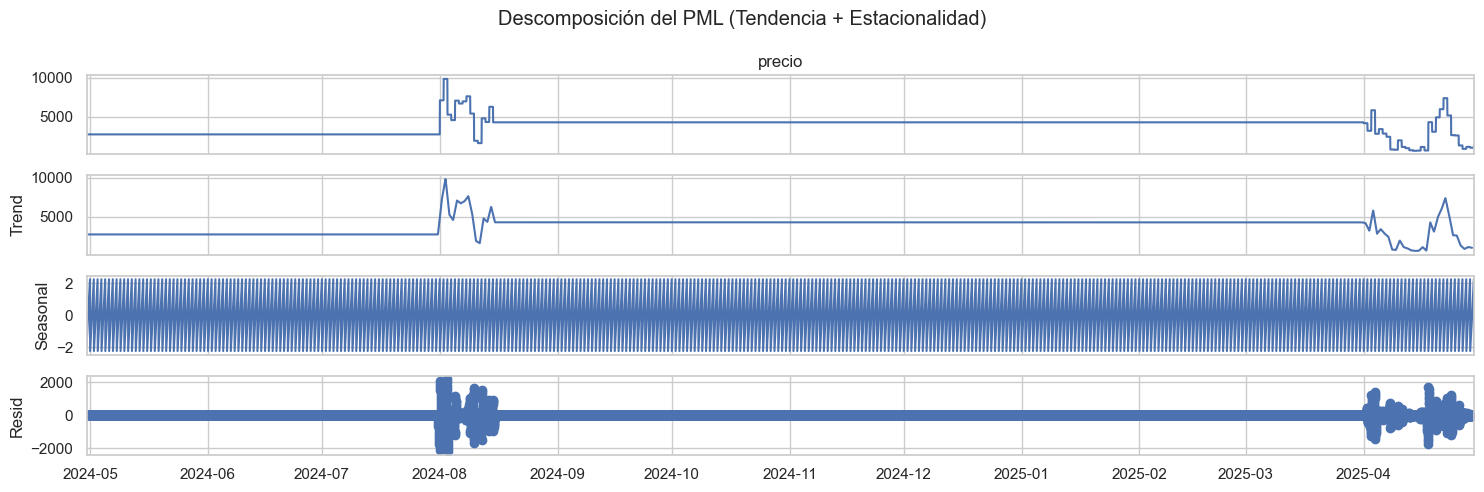

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Descomposición aditiva (tendencia + estacionalidad + residual)
df_ts = df.set_index('fecha')['precio'].resample('h').mean().ffill()
result = seasonal_decompose(df_ts[-365*24:], model='additive', period=24) # Último año, estacionalidad diaria (24h)
result.plot()
plt.suptitle('Descomposición del PML (Tendencia + Estacionalidad)')
plt.tight_layout()
plt.show()

## 8. Outliers y Datos Anómalos

⚠️ Número de outliders en PML: 1784 


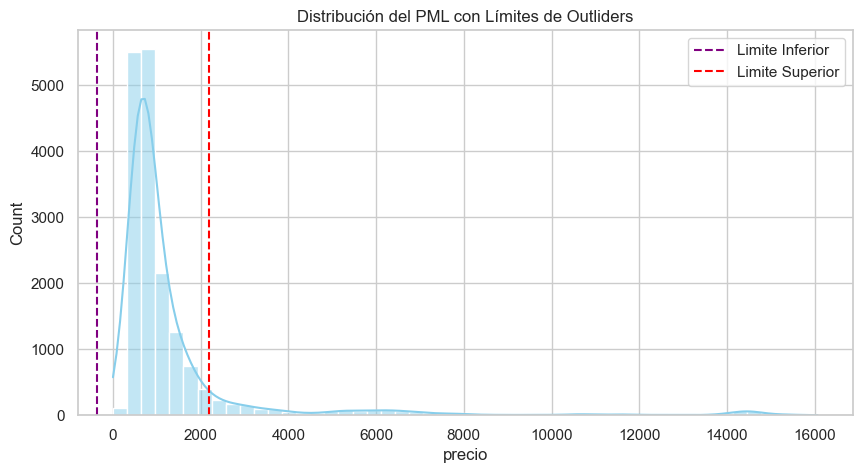

In [9]:
# Detección de outliers (IQR)
Q1 = df['precio'].quantile(0.25)
Q3 = df['precio'].quantile(0.75)
IQR = Q3 - Q1
outliders = df[(df['precio'] < (Q1 - 1.5 * IQR)) | (df['precio'] > (Q3 + 1.5 * IQR))]
print(f"⚠️ Número de outliders en PML: {len(outliders)} ")

# Gráfico de distribución
plt.figure(figsize=(10, 5))
sns.histplot(df['precio'], kde=True, bins=50, color='skyblue')
plt.axvline(Q1 - 1.5 * IQR, color='purple', linestyle='--', label='Limite Inferior')
plt.axvline(Q3 + 1.5 * IQR, color='red', linestyle='--', label='Limite Superior')
plt.title('Distribución del PML con Límites de Outliders')
plt.legend()
plt.show()

## 9. Relación entre congestión y PML agrupada por mes

In [ ]:
import plotly.express as px
import pandas as pd

def plot_heatmap_congestion_pml(df):
    """
    Heatmap de congestión vs PML promedio por mes
    
    Parámetros:
    df -- DataFrame con columnas: fecha (datetime), congestion (float), precio (float)
    """
    try:
        # Crear copia para no modificar el DataFrame original
        df_plot = df.copy()
        
        # Extraer nombre del mes en español
        df_plot['mes'] = df_plot['fecha'].dt.month_name(locale='es')
        
        # Definir orden de meses en español
        meses_orden = [
            'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
            'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'
        ]
        
        # Convertir a categoría ordenada
        df_plot['mes'] = pd.Categorical(
            df_plot['mes'], 
            categories=meses_orden, 
            ordered=True
        )
        
        # Crear el heatmap
        fig = px.density_heatmap(
            df_plot,
            x='mes',
            y='congestion',
            z='precio',
            histfunc='avg',
            nbinsx=12,
            nbinsy=20,
            color_continuous_scale='Rainbow',
            title='Relación entre Congestión y PML Promedio por Mes',
            labels={
                'congestion': 'Congestión ($/MWh)',
                'precio': 'PML Promedio ($/MWh)',
                'mes': 'Mes del año'
            }
        )
        
        # Personalizar el layout
        fig.update_layout(
            xaxis_title='Mes',
            yaxis_title='Nivel de Congestión ($/MWh)',
            coloraxis_colorbar={
                'title': 'PML Promedio',
                'tickprefix': '$',
                'ticksuffix': '/MWh'
            }
        )
        
    
        
    except Exception as e:
        print(f"Error al generar el heatmap: {str(e)}")
        print("Verifica que tu DataFrame tenga las columnas correctas:")
        print("- fecha (datetime)")
        print("- congestion (numérico)")
        print("- precio (numérico)")

# Llamar a la función
plot_heatmap_congestion_pml(df)

import plotly.express as px
import pandas as pd

def plot_heatmap_congestion_pml(df):
    """
    Heatmap de congestión vs PML promedio por mes
    
    Parámetros:
    df -- DataFrame con columnas: fecha (datetime), congestion (float), precio (float)
    """
    try:
        # Crear copia para no modificar el DataFrame original
        df_plot = df.copy()
        
        # Extraer nombre del mes en español
        df_plot['mes'] = df_plot['fecha'].dt.month_name(locale='es')
        
        # Definir orden de meses en español
        meses_orden = [
            'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
            'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'
        ]
        
        # Convertir a categoría ordenada
        df_plot['mes'] = pd.Categorical(
            df_plot['mes'], 
            categories=meses_orden, 
            ordered=True
        )
        
        # Crear el heatmap
        fig = px.density_heatmap(
            df_plot,
            x='mes',
            y='congestion',
            z='precio',
            histfunc='avg',
            nbinsx=12,
            nbinsy=20,
            color_continuous_scale='Rainbow',
            title='Relación entre Congestión y PML Promedio por Mes',
            labels={
                'congestion': 'Congestión ($/MWh)',
                'precio': 'PML Promedio ($/MWh)',
                'mes': 'Mes del año'
            }
        )
        
        # Personalizar el layout
        fig.update_layout(
            xaxis_title='Mes',
            yaxis_title='Nivel de Congestión ($/MWh)',
            coloraxis_colorbar={
                'title': 'PML Promedio',
                'tickprefix': '$',
                'ticksuffix': '/MWh'
            }
        )
        
        fig.show()
        
    except Exception as e:
        print(f"Error al generar el heatmap: {str(e)}")
        print("Verifica que tu DataFrame tenga las columnas correctas:")
        print("- fecha (datetime)")
        print("- congestion (numérico)")
        print("- precio (numérico)")
        
    fig.write_html("heatmap.html")

# Llamar a la función
plot_heatmap_congestion_pml(df)

 ## 10. Análisis por hora
 - Comportamiento del precio a lo largo del día
 - Distribución horaria del precio de energía

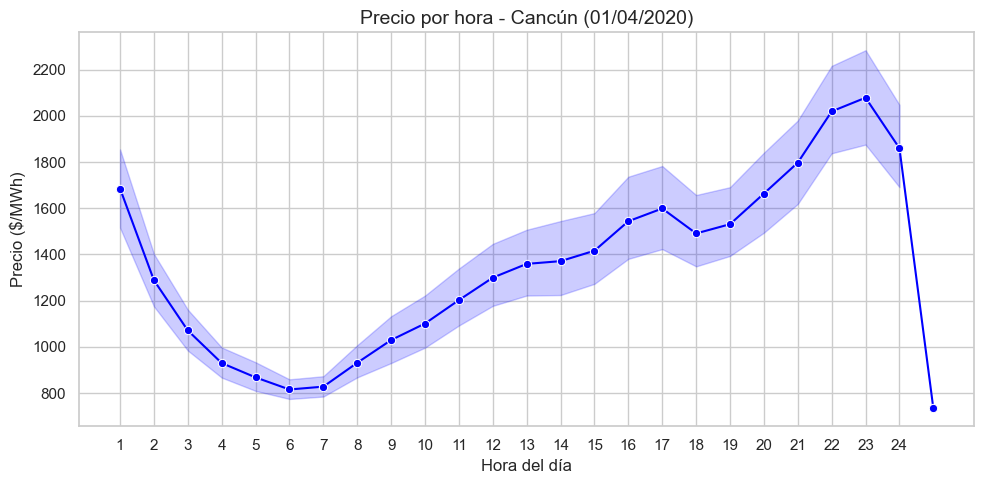

In [13]:
# Asegurar de que 'hora' esté ordenada numéricamente
df_sorted = df.sort_values('hora')

sns.set(style='whitegrid')

plt.figure(figsize=(10,5))
sns.lineplot(x='hora', y='precio', data=df_sorted, marker='o', color='blue')
plt.title('Precio por hora - Cancún (01/04/2020)', fontsize=14)
plt.xlabel('Hora del día', fontsize=12)
plt.ylabel('Precio ($/MWh)', fontsize=12)
plt.xticks(range(1, 25))
plt.tight_layout()
plt.show()

## 11. Conclusiones del EDA

## **Hallazgos clave:**
 
- Patrón horario claro: Picos a las **horas pico**

- Estacionalidad **mensual:** Precios más altos en meses de alta demanda

- **Correlación positiva** entre congestión y PML

- Outliers en PML: *X%* de los datos (posibles errores o eventos extremos)


